In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
# from torch.nn import TripletMarginLoss
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score
import PIL.ImageOps    

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    train_batch_size = 1
    train_number_epochs = 8

In [4]:
training_dir = "/home/care1e55/study/DBO/project/data/train"
testing_dir = "/home/care1e55/study/DBO/project/data/test"
training_csv="/home/care1e55/study/DBO/project/clean/combined_triplet_train.csv"    
testing_csv="/home/care1e55/study/DBO/project/clean/combined_triplet_test.csv"


In [5]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [6]:
pd.read_csv(training_csv).head(2)

,sample
0,1111139/8.png
1,1111139/16.png


In [7]:
class HardTripletDataset():
    def __init__(self, base_path, transform=None):
        self.transform = transform
        self.genuie = []
        self.forged = []
        # self.base_path = './gpds/combined/combined'
        self.base_path = base_path
        self.dataframes = []
        files_list = []

        for root, dirs, files in tqdm(os.walk(self.base_path)):
            if files:
                self.dataframes.append([os.path.join(root.split("/")[-1], file) for file in files ])

        dataframes = self.dataframes
        for i in tqdm(range(len(dataframes))):
            if '_forg' not in dataframes[i][0]:
                cur_genuie = dataframes[i]
                for j, dataframe in enumerate(dataframes):
                    if dataframes[i][0].split("/")[0]+"_forg" == dataframes[j][0].split("/")[0]:
                        cur_forg = dataframes[j]
                        break 
                self.genuie.append(cur_genuie)
                self.forged.append(cur_forg)

    def __len__(self):
        return int(len(self.dataframes)//2)
    
    def __getitem__(self, index):
        cur_genuie = self.genuie[index]
        cur_forged = self.forged[index]
        cur_genuie_batch = self.prepare_batch(cur_genuie)
        cur_forged_batch = self.prepare_batch(cur_forged)
        return cur_genuie_batch, cur_forged_batch
    

    def prepare_batch(self, batch):
        for n, i in enumerate(batch):
            cur_img = Image.open(os.path.join(self.base_path,i)).convert('L')
            # cur_img = ImageEnhance.Contrast(cur_img).enhance(1.5)
            # cur_img = ImageEnhance.Brightness(cur_img).enhance(1.5)
            # cur_img = PIL.ImageOps.invert(cur_img)
            cur_img = cur_img.convert('RGB')
            cur_img.load()
            if self.transform is not None:
                cur_img = self.transform(cur_img)
            if n == 0:
                prepared_batch = cur_img.unsqueeze(0)
            else:
                prepared_batch = torch.cat((prepared_batch, cur_img.unsqueeze(0)), 0)            
        return prepared_batch

    
    def prepare_one(self, one):
        cur_img = Image.open(os.path.join(self.base_path,one)).convert('L')
        # cur_img = PIL.ImageOps.invert(cur_img)
        cur_img = cur_img.convert('RGB')
        cur_img.load()
        if self.transform is not None:
            cur_img = self.transform(cur_img)
        return cur_img
    

In [8]:
transform = transforms.Compose([
  # transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
  # # transforms.RandomRotation(degrees = 15, fill=0),
  # torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
  # transforms.RandomAffine(
  #   degrees=(-10, 10), 
  #   translate=(0.2,0.2), 
  #   scale=(0.8,1.2), 
  #   shear=None, 
  #   resample=False, 
  #   fillcolor=(0,0,0)),
  transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [9]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
        # self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 1024),
                # nn.Dropout2d(p=0.2),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 128),
            )

    #     num_ftrs = self.resnet.fc.in_features
    #     self.resnet.fc = nn.Sequential(
    #     nn.Linear(num_ftrs, 512),
    #     nn.ReLU(inplace=True),
    #     nn.Dropout2d(p=0.2),
    #     nn.Linear(512, 128),
    #     # nn.ReLU(inplace=True),
    #     # nn.Linear(128,2)
    # )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2):
        pos_features = self.forward_once(input1)
        neg_features = self.forward_once(input2)


        pos_idx = torch.argmax(torch.cdist(pos_features.detach(), pos_features.detach(), p=2.0), 0)
        neg_idx = torch.argmin(torch.cdist(neg_features.detach(), pos_features.detach(), p=2.0), 0)
        
        return pos_features, pos_features[pos_idx], neg_features[neg_idx]

    def inference(self, x):
        # self.resnet.eval()
        with torch.no_grad():
            output = self.resnet(x)
            return output

In [11]:
net = SiameseNetwork().cuda()

In [12]:
# train_datasdet = HardTripletDataset(training_dir, transform=transform)
train_datasdet = HardTripletDataset(testing_dir, transform=transform)

129it [00:00, 24048.41it/s]
100%|██████████| 128/128 [00:00<00:00, 70585.18it/s]


In [13]:
# vis_dataloader = DataLoader(train_datasdet, shuffle=True, batch_size=1)
# dataiter = iter(vis_dataloader)
# example_batch = next(dataiter)
# print(example_batch[1].size())
# result = net(example_batch[0].squeeze(0).cuda(), example_batch[1].squeeze(0).cuda())
# print(result[0].size(), result[1].size(), result[2].size())

In [14]:
print(net)

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [16]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [17]:
def fit_epoch(net, train_files, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    log_template = "\nIteration {ep:03d} train_loss: {t_loss:0.4f}"  
    
    for i, data in tqdm(enumerate(train_files,0), total = len(train_files)):
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        # print(img0.size())
        optimizer.zero_grad()
        output1, output2, output3 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, output3)
        loss_contrastive.backward()
        optimizer.step()
        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
          
    train_loss = running_loss / processed_data

    return train_loss

In [18]:
def train(train_files, net, epochs, batch_size):
    # train_dataloader = DataLoader(train_files,
    #                     shuffle=True,
    #                     num_workers=4,
    #                     batch_size=batch_size)

    history = []
   
    opt = optim.AdamW(net.parameters(), lr=0.001)
    # scheduler = StepLR(opt, step_size=1, gamma=0.5)
    scheduler = StepLR(opt, step_size=2, gamma=0.5)
    scheduler = StepLR(opt, base_lr = 0.0001, max_lr = 0.0001,  step_size_up=5, step_size_down=5)
    # criterion = TripletLoss(margin=2)
    criterion = nn.TripletMarginLoss(margin = 2.0)

    for epoch in range(epochs):
        print("Epoch:", epoch)
        # train_loss = fit_epoch(net, train_dataloader, criterion, opt)
        train_loss = fit_epoch(net, train_files, criterion, opt)
        print("loss:", train_loss)
        
        scheduler.step()
        history.append((train_loss))
                 
    return history

In [19]:
# train_datasdet[41]

In [20]:
train_datasdet.genuie[41]

['027/06_027.png',
 '027/02_027.png',
 '027/11_027.png',
 '027/05_027.png',
 '027/03_027.png',
 '027/01_027.png',
 '027/10_027.png',
 '027/07_027.png',
 '027/08_027.png',
 '027/12_027.png',
 '027/09_027.png',
 '027/04_027.png']

In [21]:
# history = train(train_datasdet, net=net, epochs=Config.train_number_epochs, batch_size=Config.train_batch_size)
history = train(train_datasdet, net=net, epochs=24, batch_size=1)

  0%|          | 0/64 [00:00<?, ?it/s]loss: 1.9815326333885934
Epoch: 1
  0%|          | 0/64 [00:00<?, ?it/s]loss: 1.1086221731098824
Epoch: 2
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.20466284391710696
Epoch: 3
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.016490403201594832
Epoch: 4
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.016638520874057844
Epoch: 5
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.0
Epoch: 6
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.0
Epoch: 7
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.0
Epoch: 8
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.0
Epoch: 9
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.0
Epoch: 10
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.0
Epoch: 11
  0%|          | 0/64 [00:00<?, ?it/s]loss: 0.0
Epoch: 12
 12%|█▎        | 8/64 [00:03<00:22,  2.54it/s]


KeyboardInterrupt: 

In [30]:
torch.save(net.state_dict(), "/home/care1e55/study/DBO/project/models/model_hard_sampling_combined.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [31]:
net.load_state_dict(torch.load("/home/care1e55/study/DBO/project/models/model_hard_sampling_combined.pt"))

<All keys matched successfully>

In [24]:
transform = transforms.Compose([
# transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [35]:
class TestDataset():
    
    def __init__(self,training_csv=None,base_path=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.base_path = base_path    
        self.transform = transform

    def __getitem__(self,index):
        
        img0 = self.prepare_one(self.training_df.iat[index,0])
        img1 = self.prepare_one(self.training_df.iat[index,1])
            
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def prepare_one(self, one):
        cur_img = Image.open(os.path.join(self.base_path,one)).convert('L')
        # cur_img = ImageEnhance.Contrast(cur_img).enhance(1.5)
        # cur_img = ImageEnhance.Brightness(cur_img).enhance(1.5)
    
        # cur_img = PIL.ImageOps.invert(cur_img)
        cur_img = cur_img.convert('RGB')
        cur_img.load()
        if self.transform is not None:
            cur_img = self.transform(cur_img)
        return cur_img
    
    def __len__(self):
        return len(self.training_df)

In [30]:
test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/test_combined_constrative_data.csv", "/home/care1e55/study/DBO/project/data/test/", transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=128, shuffle=True)
# test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/train_combined_constrative_data.csv", "/home/care1e55/study/DBO/project/data/train/", transform=transform)
# test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=128, shuffle=True)

In [31]:
net.eval()
for t in np.arange(0.05,1.0,0.05):
    targets = []
    predictions = []
    threshhold = torch.FloatTensor([t]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1, label = data
        output1 = net.inference(x0.cuda())
        output2 = net.inference(x1.cuda())
        eucledian_distance = F.pairwise_distance(output1, output2)
        targets += [int(*i) for i in label.tolist()]
        predictions += [int(i) for i in (eucledian_distance > threshhold).tolist()]

    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{t} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{t} f1:", f1_score(n_targets, n_predictions, average='weighted'))

  0%|          | 0/189 [00:00<?, ?it/s]0.05 acc: 0.5736520981197858
0.05 f1: 0.5368176339326114
  0%|          | 0/189 [00:00<?, ?it/s]0.1 acc: 0.6198895944880256
0.1 f1: 0.6208021893734369
 39%|███▊      | 73/189 [01:08<01:48,  1.07it/s]


KeyboardInterrupt: 

In [29]:
net.eval()
for t in np.arange(5.0,8.0,1.0):
    targets = []
    predictions = []
    threshhold = torch.FloatTensor([t]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1, label = data
        output1 = net.inference(x0.cuda())
        output2 = net.inference(x1.cuda())
        eucledian_distance = F.pairwise_distance(output1, output2)
        targets += [int(*i) for i in label.tolist()]
        predictions += [int(i) for i in (eucledian_distance > threshhold).tolist()]
    
    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{t} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{t} f1:", f1_score(n_targets, n_predictions, average='weighted'))

  0%|          | 0/189 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [36]:
test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/test_combined_constrative_data.csv", "/home/care1e55/study/DBO/project/data/test/", transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)
# test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/train_combined_constrative_data.csv", "/home/care1e55/study/DBO/project/data/train/", transform=transform)
# test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


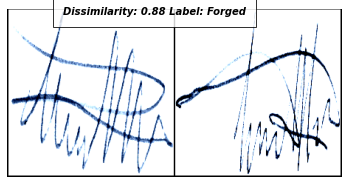

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


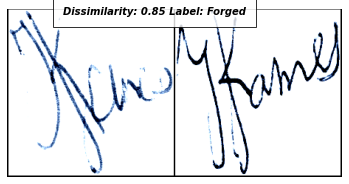

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


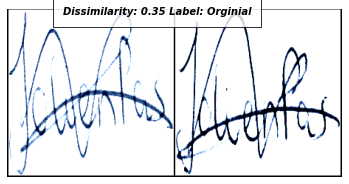

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


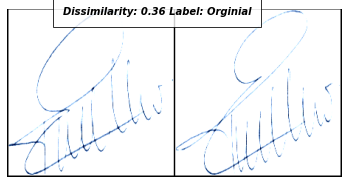

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


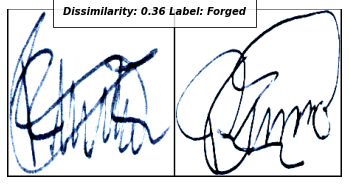

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


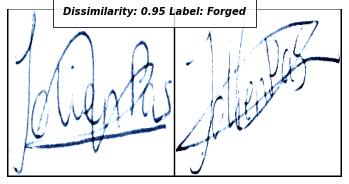

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


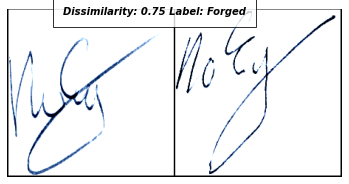

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


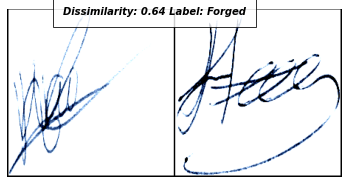

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


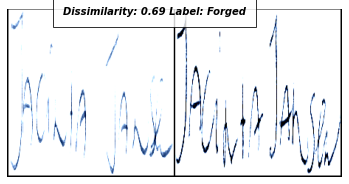

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


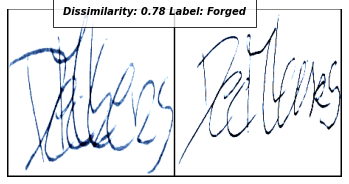

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


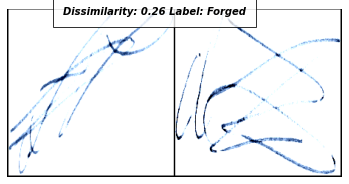

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


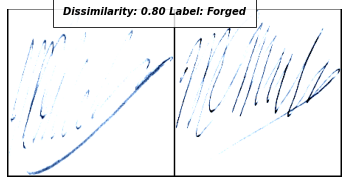

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


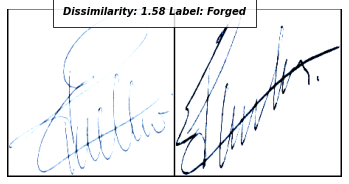

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


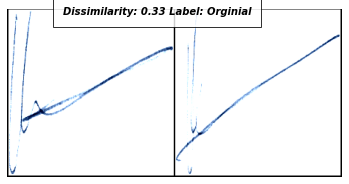

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


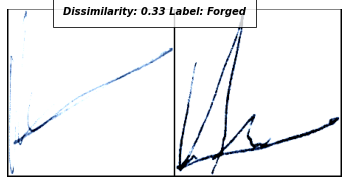

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


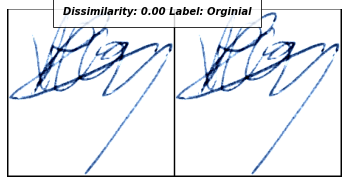

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


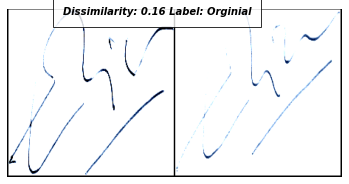

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


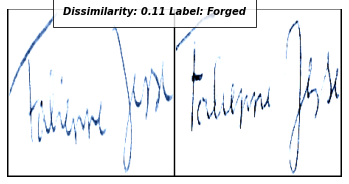

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


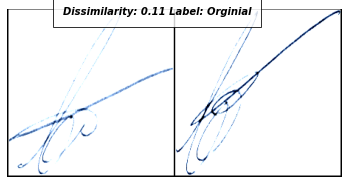

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


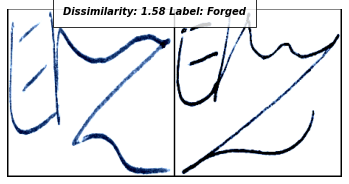

In [40]:
# Print the sample outputs to view its dissimilarity
net.eval()
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1 = net.inference(x0.to(device))
  output2 = net.inference(x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [69]:
n_predictions.shape
n_targets

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]])

In [ ]:
# torch.Size([1, 128])
# torch.Size([1, 128])
# tensor([13.4110], device='cuda:0')
# tensor([[0.]])


In [36]:
for t in np.arange(4,23,2):
    targets = []
    predictions = []
    list_0 = torch.FloatTensor([[0]])
    list_1 = torch.FloatTensor([[1]])
    # threshhold = torch.FloatTensor([50.0]).cuda()
    threshhold = torch.FloatTensor([t]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1 , label = data
        output1 = net.inference(x0.to(device))
        output2 = net.inference(x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2)
        if label==list_0:
            targets.append(0)
        else:
            targets.append(1)
        
        if eucledian_distance <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)

    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{t} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{t} f1:", f1_score(n_targets, n_predictions, average='weighted'))

  0%|          | 0/24093 [00:00<?, ?it/s]4 acc: 0.558087411281285
4 f1: 0.5225057176028709
  0%|          | 0/24093 [00:00<?, ?it/s]6 acc: 0.5948200722201469
6 f1: 0.5862206892740675
  0%|          | 0/24093 [00:00<?, ?it/s]8 acc: 0.6180633378989748
8 f1: 0.6183687156684835
  0%|          | 0/24093 [00:00<?, ?it/s]10 acc: 0.6266550450338273
10 f1: 0.6275328091211855
  0%|          | 0/24093 [00:00<?, ?it/s]12 acc: 0.6301830407172208
12 f1: 0.6267181281813797
  0%|          | 0/24093 [00:00<?, ?it/s]14 acc: 0.6328394139376582
14 f1: 0.6220232551189894
  0%|          | 0/24093 [00:00<?, ?it/s]16 acc: 0.6307226165276222
16 f1: 0.6104599906265712
  0%|          | 0/24093 [00:00<?, ?it/s]18 acc: 0.6266965508653966
18 f1: 0.5956533655518796
 35%|███▌      | 8466/24093 [01:56<03:35, 72.65it/s]


KeyboardInterrupt: 

In [31]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.616669566730468

In [219]:
f1_score(n_targets, n_predictions, average='weighted')

0.5799401125640055

In [81]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.7847206888937956

In [82]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

1.1999682590065068

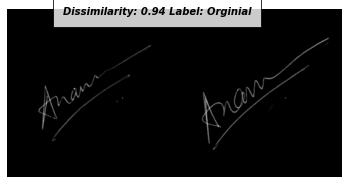

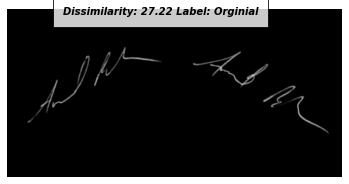

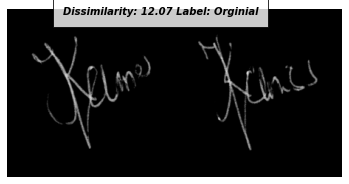

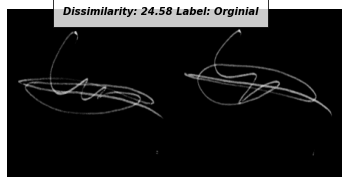

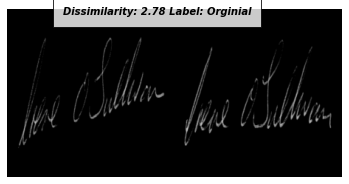

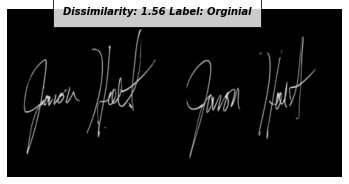

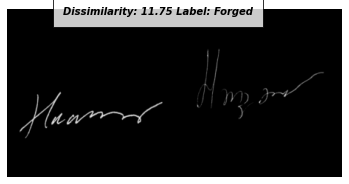

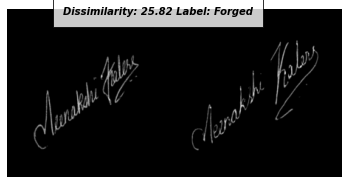

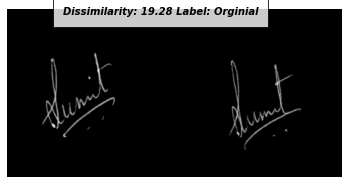

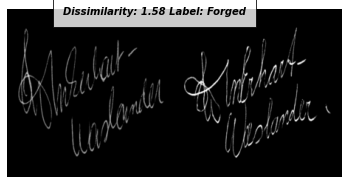

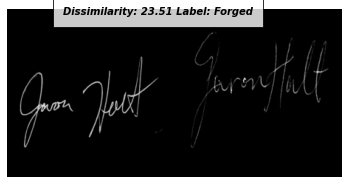

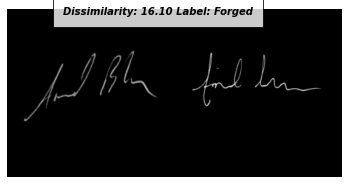

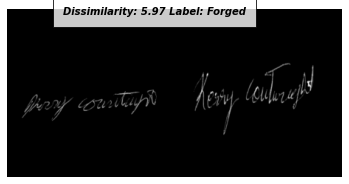

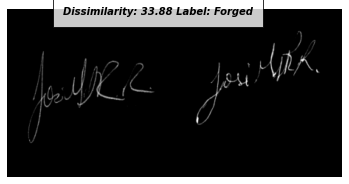

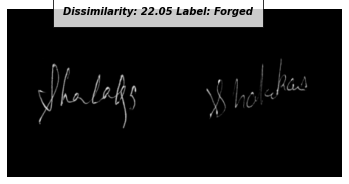

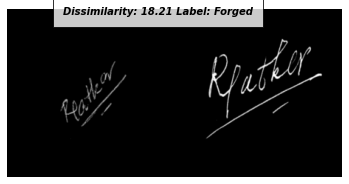

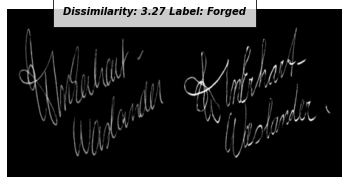

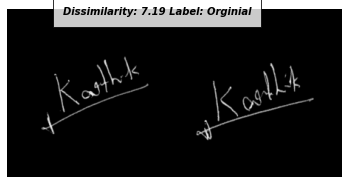

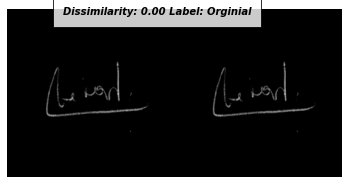

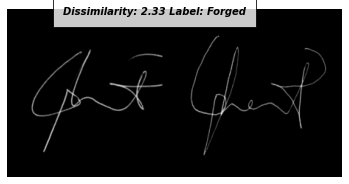

In [39]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1 = net.inference(x0.to(device))
  output2 = net.inference(x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [35]:
test_dataset = HardTripletDataset(testing_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

201it [00:00, 13959.25it/s]
100%|██████████| 200/200 [00:00<00:00, 37521.17it/s]


In [28]:
test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/test_sign_constrative_data.csv", testing_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

In [36]:
for j in range(5,15,1):
    targets = []
    predictions = []
    list_0 = torch.FloatTensor([[0]])
    list_1 = torch.FloatTensor([[1]])
    # threshhold = torch.FloatTensor([50.0]).cuda()
    threshhold = torch.FloatTensor([float(j)]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1, x3 = data
        output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))

        eucledian_distance1 = F.pairwise_distance(output1, output2)
        eucledian_distance2 = F.pairwise_distance(output1, output3)
        
        targets.append(0)
        targets.append(1)
        
        if eucledian_distance1 <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)

        if eucledian_distance2 <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)

    
    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{j} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{j} f1:", f1_score(n_targets, n_predictions, average='weighted'))

0%|          | 0/100 [00:01<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [33]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
# threshhold = torch.FloatTensor([50.0]).cuda()
threshhold = torch.FloatTensor([10.0]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1, x3 = data
    output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))

    eucledian_distance1 = F.pairwise_distance(output1, output2)
    eucledian_distance2 = F.pairwise_distance(output1, output3)
    
    targets.append(0)
    targets.append(1)
    
    if eucledian_distance1 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

    if eucledian_distance2 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

0%|          | 0/100 [00:01<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [235]:
from sklearn.metrics import f1_score

In [236]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.5238095238095238

In [237]:
f1_score(n_targets, n_predictions, average='weighted')

0.38416422287390034

In [238]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.9523809523809523

In [239]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
    

In [29]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 ,x3 = data
  concatenated1 = torch.cat((x0,x1),0)
  concatenated2 = torch.cat((x0,x3),0)
  output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))
  eucledian_distance1 = F.pairwise_distance(output1, output2)
  eucledian_distance2 = F.pairwise_distance(output1, output3)
  label="Orginial"
  imshow(torchvision.utils.make_grid(concatenated1),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance1.item(),label))
  label="Forged"
  imshow(torchvision.utils.make_grid(concatenated2),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance2.item(),label))
  counter=counter+1
  if counter ==20:
     break

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/care1e55/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/care1e55/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/care1e55/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-21-ecfaf0f791b8>", line 12, in __getitem__
    img0 = self.prepare_one(self.training_df.iat[index,0])
  File "<ipython-input-21-ecfaf0f791b8>", line 18, in prepare_one
    cur_img = Image.open(os.path.join(self.base_path,one)).convert('L')
  File "/home/care1e55/.local/lib/python3.6/site-packages/PIL/Image.py", line 2843, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/care1e55/study/DBO/project/gpds/combined/combined/test/062/12_062.png'
